In [1]:
import numpy as np
import scipy.sparse as sparse
import time
import pickle
from igraph import *
from hits_hubs.dataset_fetcher import ListToMatrixConverter
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import time

In [2]:

debug = False


class HITS():
    """An instance of HITS is used to model the idea of hubs and authorities
    and execute the corresponding algorithm
    """

    def __init__(self, link_matrix, users, index_id_map, is_sparse=False):
        """
        Initializes an instance of HITS

        Args:
            link_matrix: The link matrix
            users: Details of all users
            index_id_map: Dictionary representing a map from link matrix index
            to user id
            is_sparse: True if the links matrix is a sparse matrix
        """
        self.__is_sparse = is_sparse
        self.__link_matrix = link_matrix
        self.__link_matrix_tr = link_matrix.transpose()
        self.__n = self.__link_matrix.shape[0]
        self.__hubs = np.ones(self.__n)
        self.__auths = np.ones(self.__n)
        self.__size = 30
        self.__names = [users[index_id_map[i]]['screen_name'] for i in range(0, self.__size)]
        self.__index_id_map = index_id_map
        self.__users = users
        self.all_hubs = []
        self.all_auths = []

    def calc_scores(self, epsilon=1e-4):
        """Calculates hubbiness and authority
        """
        epsilon_matrix = epsilon * np.ones(self.__n)
        if self.__is_sparse:
            while True:
                hubs_old = self.__hubs
                auths_old = self.__auths

                self.__auths = self.__link_matrix_tr * hubs_old
                max_score = self.__auths.max(axis=0)
                if max_score != 0:
                    self.__auths = self.__auths / max_score
                self.all_auths.append(self.__auths)

                self.__hubs = self.__link_matrix * self.__auths
                max_score = self.__hubs.max(axis=0)
                if max_score != 0:
                    self.__hubs = self.__hubs / max_score
                self.all_hubs.append(self.__hubs)

                if (((abs(self.__hubs - hubs_old)) < epsilon_matrix).all()) and (
                ((abs(self.__auths - auths_old)) < epsilon_matrix).all()):
                    break

        else:
            while True:
                hubs_old = self.__hubs
                auths_old = self.__auths

                self.__auths = np.dot(self.__link_matrix_tr, hubs_old)
                max_score = self.__auths.max(axis=0)
                if max_score != 0:
                    self.__auths = self.__auths / max_score
                self.all_auths.append(self.__auths)

                self.__hubs = np.dot(self.__link_matrix, self.__auths)
                max_score = self.__hubs.max(axis=0)
                if max_score != 0:
                    self.__hubs = self.__hubs / max_score
                self.all_hubs.append(self.__hubs)

                if (((abs(self.__hubs - hubs_old)) < epsilon_matrix).all()) and (
                ((abs(self.__auths - auths_old)) < epsilon_matrix).all()):
                    break

    def get_all_hubs(self):
        """Returns the hubbiness score for each user for each iteration
        """
        return self.all_hubs

    def get_all_auths(self):
        """Returns the authority score for each user for each iteration
        """
        return self.all_auths

    def get_hubs(self):
        """Returns the hubbiness for each node (user)
        """
        return self.__hubs

    def get_auths(self):
        """Returns the authority for each node (user)
        """
        return self.__auths

    def get_names(self):
        """Returns the screen name of each user
        """
        return self.__names

    def plot_graph(self, x, names, c):
        """Plots the graph
        """
        if self.__is_sparse:
            g = Graph.Adjacency((self.__link_matrix[0:self.__size, 0:self.__size]).toarray().tolist())
        else:
            g = Graph.Adjacency((self.__link_matrix[0:self.__size, 0:self.__size]).tolist())
        g.vs["name"] = names
        g.vs["attr"] = ["%.3f" % k for k in x]

        array_min = 0
        if x.min(axis=0) < 0.001:
            array_min = 0.001
        else:
            array_min = x.min(axis=0)

        ###layout###
        layout = g.layout("kk")
        visual_style = {}
        visual_style["vertex_size"] = [(x[i] / array_min) * 0.3 if x[i] >= 0.001 else 10 for i in
                                       range(0, min(self.__size, len(x)))]
        visual_style["vertex_label"] = [(g.vs["name"][i], float(g.vs["attr"][i])) for i in
                                        range(0, min(self.__size, len(x)))]
        color_dict = {"0": "red", "1": "yellow"}
        g.vs["color"] = color_dict[str(c)]
        visual_style["edge_arrow_size"] = 2
        visual_style["vertex_label_size"] = 35
        visual_style["layout"] = layout
        visual_style["bbox"] = (3200, 2200)
        visual_style["margin"] = 250
        visual_style["edge_width"] = 4
        plot(g, **visual_style)

    def plot_stats(self):
        screen_name_index_map = {}
        for key in self.__index_id_map:
            screen_name_index_map[self.__users[self.__index_id_map[key]]['screen_name']] = key

        cands = ['austinnotduncan', 'str_mape', 'LeoDiCaprio', 'aidanf123', 'MKBHD']
        colors = ['green', 'cyan', 'magenta', 'blue', 'brown']
        all_hubs = np.array(self.all_hubs)
        all_auths = np.array(self.all_auths)

        plt.figure(1, figsize=(12, 7))
        ax = plt.gca()
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Hubbiness Score")
        legend_handles = []
        for i in range(len(cands)):
            legend_handles.append(mp.Patch(label=cands[i], color=colors[i]))
            ax.plot(np.arange(1, all_hubs.shape[0] + 1), all_hubs[:, screen_name_index_map[cands[i]]], color=colors[i])
        ax.legend(handles=legend_handles)
        ax.set_title("Change in hubbiness score with increasing iterations")
        plt.show()

        plt.figure(2, figsize=(12, 7))
        ax = plt.gca()
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Authority Score")
        legend_handles = []
        for i in range(len(cands)):
            legend_handles.append(mp.Patch(label=cands[i], color=colors[i]))
            ax.plot(np.arange(1, all_auths.shape[0] + 1), all_auths[:, screen_name_index_map[cands[i]]],
                    color=colors[i])
        ax.legend(handles=legend_handles)
        ax.set_title("Change in authority score with increasing iterations")
        plt.show()


class DatasetReader():
    """An instance of DatasetReader is used to read different files from the
    dataset
    """

    def __init__(self):
        """Initializes an instance of DatasetReader
        """
        pass

    def read_users(self, users_path):
        """Returns the dictionary (stored in a file) containing details of
        all users

        Args:
            users_path: Path to the file where info of all users is stored
        """
        with open(users_path, mode='rb') as f:
            users = pickle.load(f)
        return users

    def read_map(self, map_path):
        """Returns the dictionary (stored in a file) that represents a map
        from the link matrix index to user id

        Args:
            map_path: Path to the file where the map is stored
        """
        with open(map_path, mode='rb') as f:
            index_id_map = pickle.load(f)
        return index_id_map

    def read_link_matrix(self, link_matrix_path, is_sparse=False):
        """Returns the array (stored in a file) that represents the link matrix

        Args:
            link_matrix_path: Path to the file where the link matrix is stored
            is_sparse: True if the link matrix is stored as a sparse matrix
        """
        with open(link_matrix_path, mode='rb') as f:
            if is_sparse:
                link_matrix = sparse.load_npz(link_matrix_path)
            else:
                link_matrix = np.load(f)
        return link_matrix


500 30


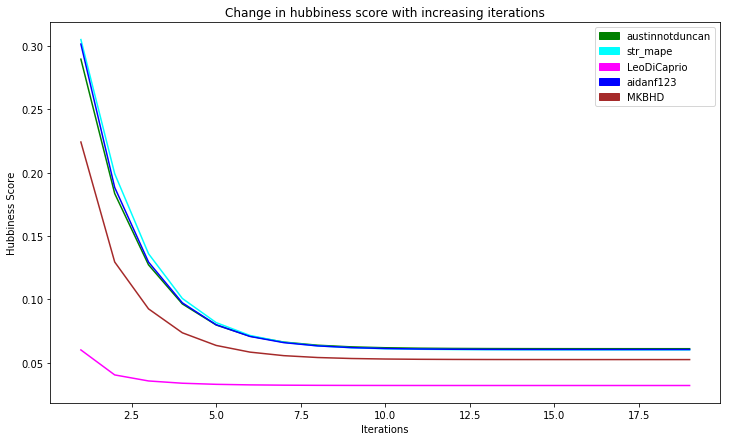

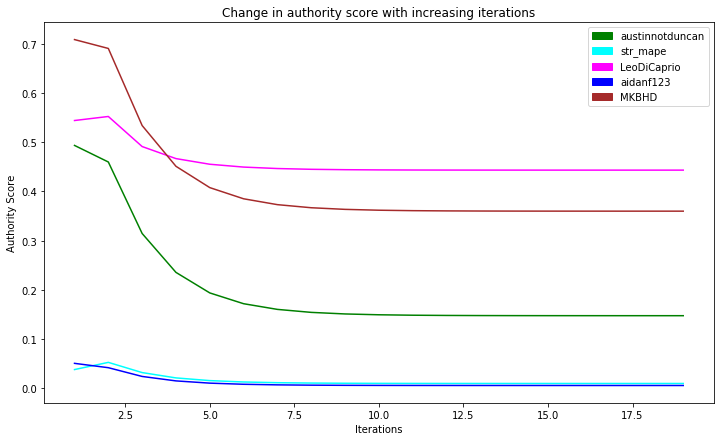

In [13]:
# is_sparse = True
epsilon = 1e-5
show_iters = False

users_path = 'data/users'
map_path = 'data/map'
sparse_link_matrix_path = 'data/sparse_link_matrix'
dense_link_matrix_path = 'data/dense_link_matrix'
if sparse:
    link_matrix_path = sparse_link_matrix_path
else:
    link_matrix_path = dense_link_matrix_path

    # Load the stored data into objects
r = DatasetReader()
users = r.read_users(users_path)
index_id_map = r.read_map(map_path)
link_matrix = r.read_link_matrix(link_matrix_path, is_sparse=True)

    # Run the algorithm
h = HITS(link_matrix, users, index_id_map, is_sparse=sparse)
h.calc_scores(epsilon=epsilon)
    # print(h.get_all_hubs())
if show_iters:
    x = h.get_all_hubs()
    for i in x:
        h.plot_graph(i, h.get_names(), 0)

    y = h.get_all_auths()
    for i in y:
        h.plot_graph(i, h.get_names(), 1)
else:
    h.plot_graph(h.get_hubs(), h.get_names(), 0)
    h.plot_graph(h.get_auths(), h.get_names(), 1)
    print(len(h.get_hubs()),len(h.get_names()))

    # Print graphs
h.plot_stats()